# Confetti

We have noted a "confetti" problem in some of the ALMA-IMF cube images.  It is called confetti because _one_ of its manifestations is individual bright pixels in the model image.

This notebook shows where confetti is - and is not a problem.

## Preliminaries: skip this

In [1]:
from spectral_cube import SpectralCube
import numpy as np
import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline
import pylab as pl
from astropy.visualization import simple_norm
pl.rcParams['font.size'] = 16

In [3]:
from astropy import units as u

## G008.67 Continuum

This is the G008.67 continuum image in Band 3.

It has "confetti" pieces in the model image, but there is no problem: no artificial point sources are introduced.

In [4]:
contmodel = SpectralCube.read('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/G008.67_B3_uid___A001_X1296_X1c1_continuum_merged_12M_robust-0.5_selfcal5_finaliter.model.tt0', format='casa_image')
contimage = SpectralCube.read('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/G008.67_B3_uid___A001_X1296_X1c1_continuum_merged_12M_robust-0.5_selfcal5_finaliter.image.tt0', format='casa_image')
contresid = SpectralCube.read('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/G008.67_B3_uid___A001_X1296_X1c1_continuum_merged_12M_robust-0.5_selfcal5_finaliter.residual.tt0', format='casa_image')

In [5]:
# zoom in
contslc = (0, slice(950,1050), slice(1900,2050))

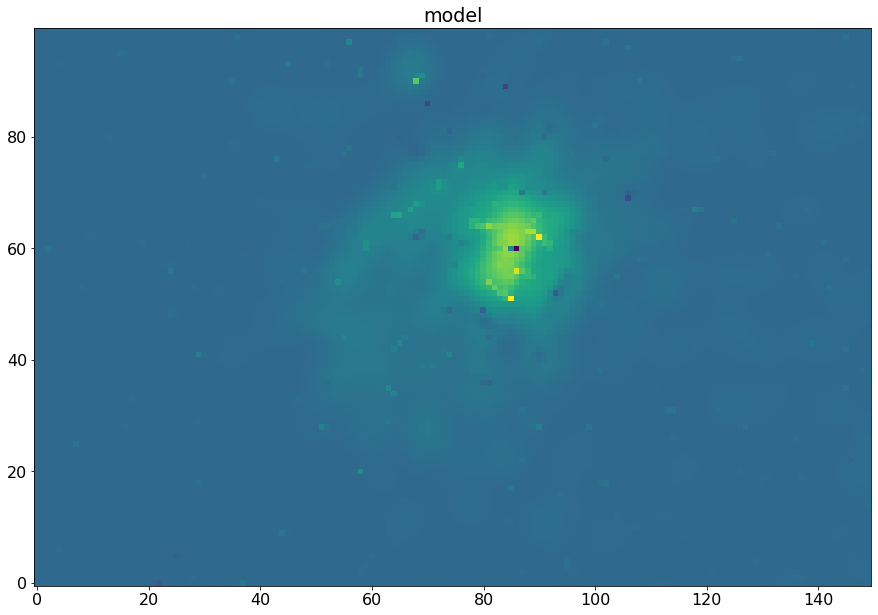

In [6]:
pl.figure(figsize=(15,15))
pl.imshow(contmodel[contslc].value, norm=simple_norm(contmodel[contslc].value, max_percent=99.995, stretch='asinh'), interpolation='none', origin='lower')
_=pl.title("model")

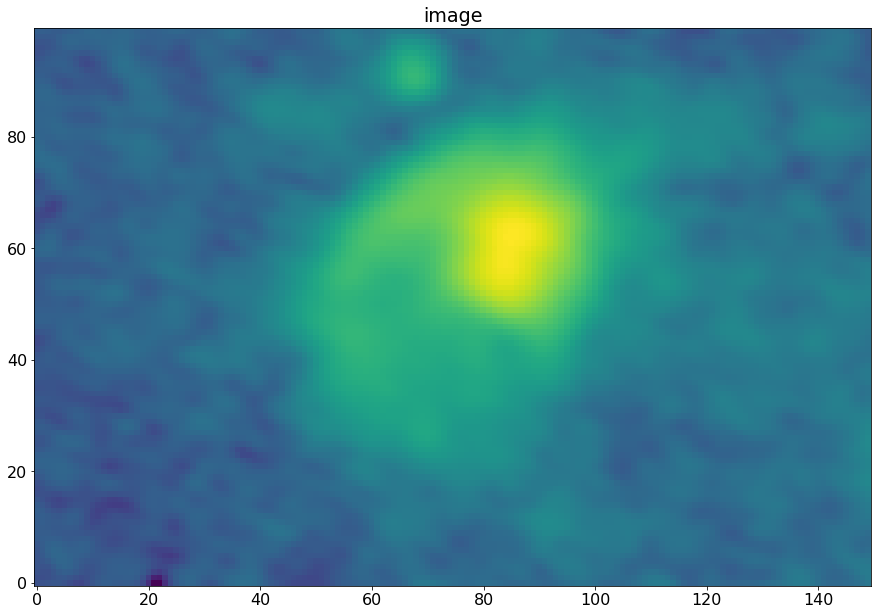

In [7]:
pl.figure(figsize=(15,15))
im = contimage[0][contslc[1:]].value
pl.imshow(im, norm=simple_norm(im, stretch='log', max_percent=99.995), interpolation='none',  origin='lower')
_=pl.title("image")

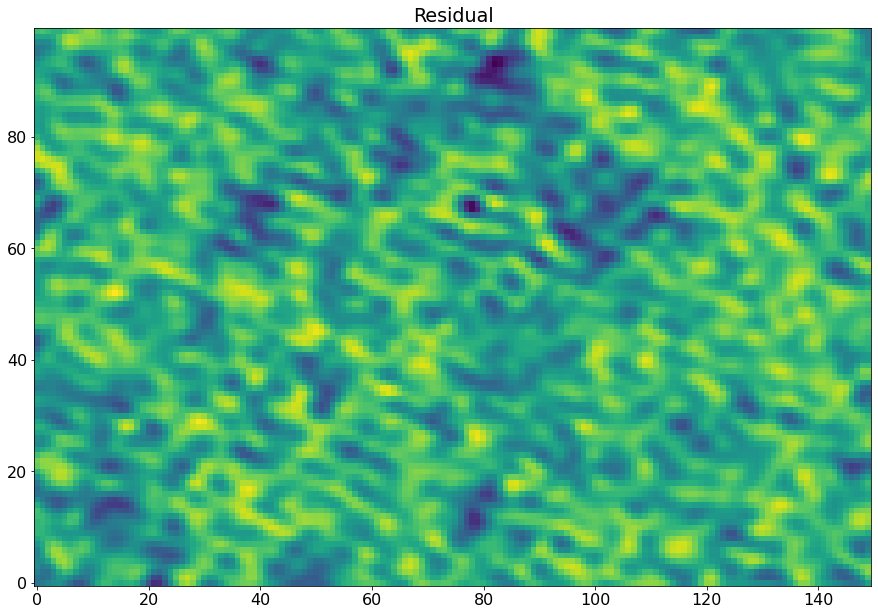

In [8]:
pl.figure(figsize=(15,15))
im = contresid[0][contslc[1:]].value
pl.imshow(im, norm=simple_norm(im, stretch='linear'), interpolation='none',  origin='lower')
_=pl.title("Residual")

# G008.67 Cube

The G008.67 cube _does_ have a problem!

In [9]:
cube = SpectralCube.read('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/G008.67_B3_spw0_12M_n2hp.image', format='casa_image').with_spectral_unit(u.km/u.s, velocity_convention='radio')
resid = SpectralCube.read('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/G008.67_B3_spw0_12M_n2hp.residual', format='casa_image').with_spectral_unit(u.km/u.s, velocity_convention='radio')
model = SpectralCube.read('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/imaging_results/G008.67_B3_spw0_12M_n2hp.model', format='casa_image').with_spectral_unit(u.km/u.s, velocity_convention='radio')

In [10]:
xslc = slice(1620,1654)
yslc = slice(709,743)
cubeslice = (slice(None), yslc, xslc)
cube1slice = (98, yslc, xslc)

## Confetti: a false (?) point source

In the image below, we see a new source introduced in the 35.140 km/s panel.

There is no comparable source in either of the adjacent panels!

That means either there is a genuinely pointlike source with linewidth much narrower than 0.77 km/s, or this source is fake.

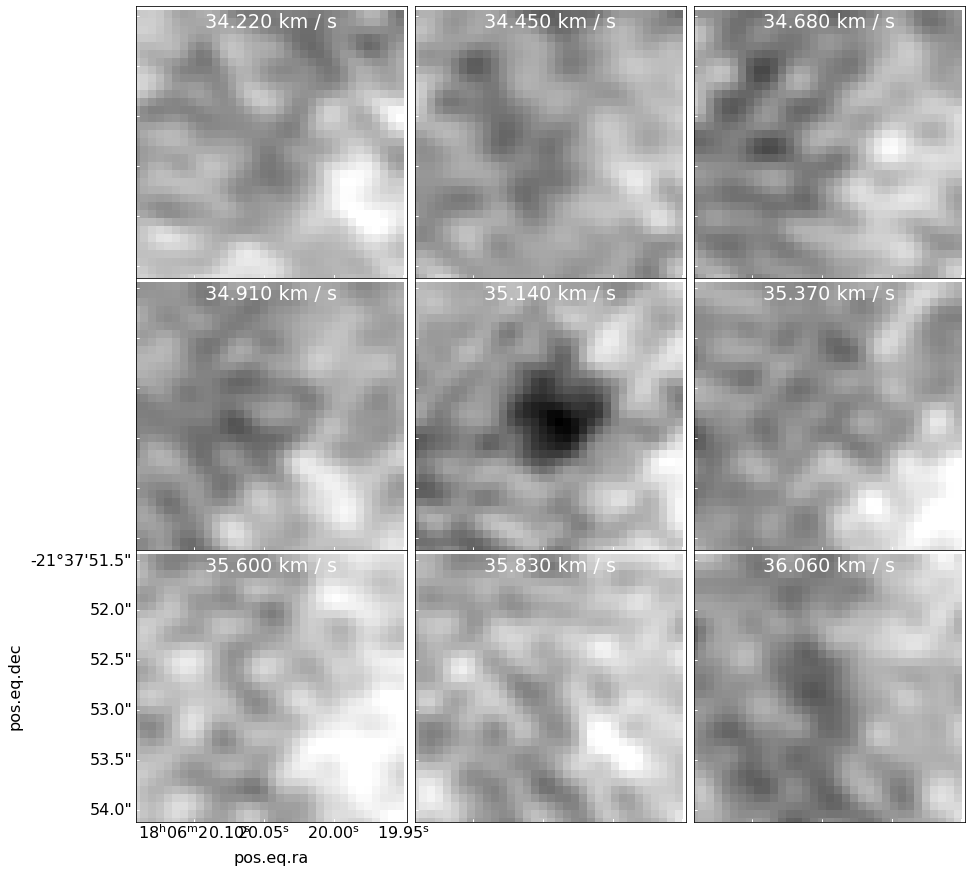

In [11]:
specpix = np.arange(94,94+9)
panels = cube[cubeslice].plot_channel_maps(3,3,specpix, fig_smallest_dim_inches=15, norm=simple_norm(cube[cube1slice].value))

It is caused by one hot (bright) pixel surrounded by many faint pixels

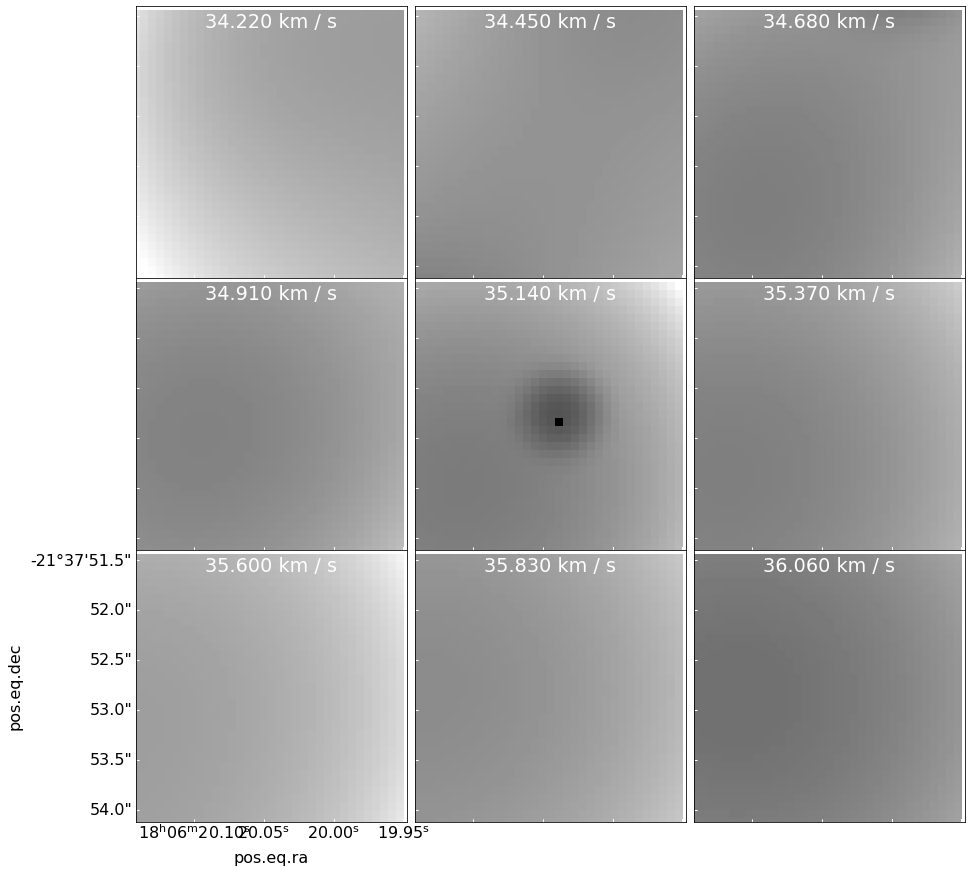

In [12]:
panels = model[cubeslice].plot_channel_maps(3,3,specpix, fig_smallest_dim_inches=15, norm=simple_norm(model[cube1slice].value, stretch='log', max_percent=99.93))

There is no sign of it in the residual - it is apparently canceled out between positive and negative components added to the model

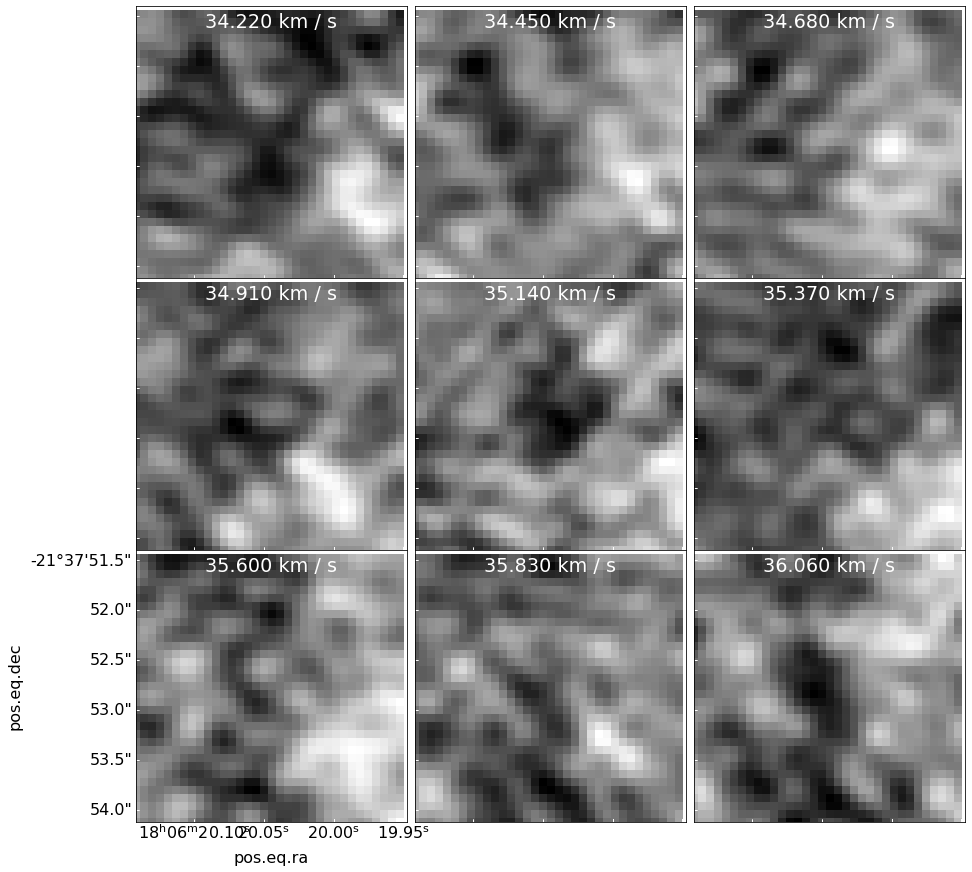

In [13]:
panels = resid[cubeslice].plot_channel_maps(3,3,specpix, fig_smallest_dim_inches=15)

The manifestation in the spectra is a very sharp peak at just one pixel.

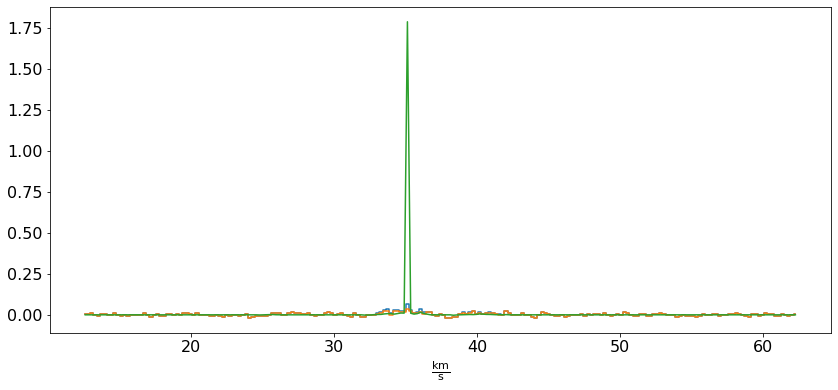

In [14]:
pl.figure(figsize=(14,6))
xx,yy=1638,725
cube[:,yy,xx].quicklook()
resid[:,yy,xx].quicklook()
modspec = model[:,yy,xx]
pl.plot(cube.spectral_axis, modspec*cube.pixels_per_beam, label='model')

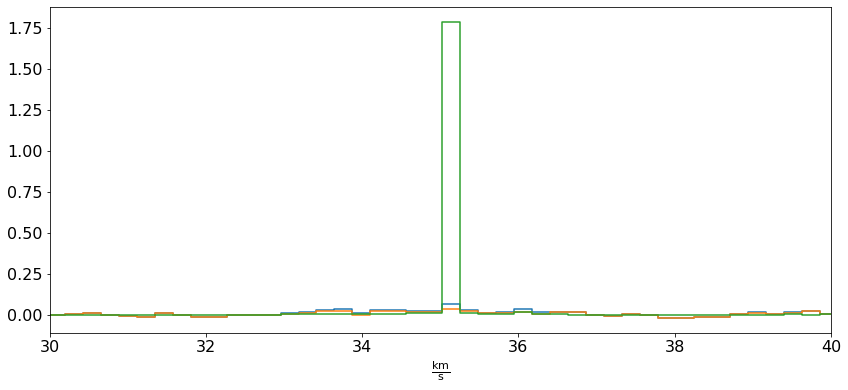

In [22]:
pl.figure(figsize=(14,6))
xx,yy=1638,725
cube[:,yy,xx].quicklook()
resid[:,yy,xx].quicklook()
modspec = model[:,yy,xx]
pl.plot(cube.spectral_axis, modspec*cube.pixels_per_beam, label='model', drawstyle='steps-mid')
pl.xlim(30,40);

Pixels to either side look fine

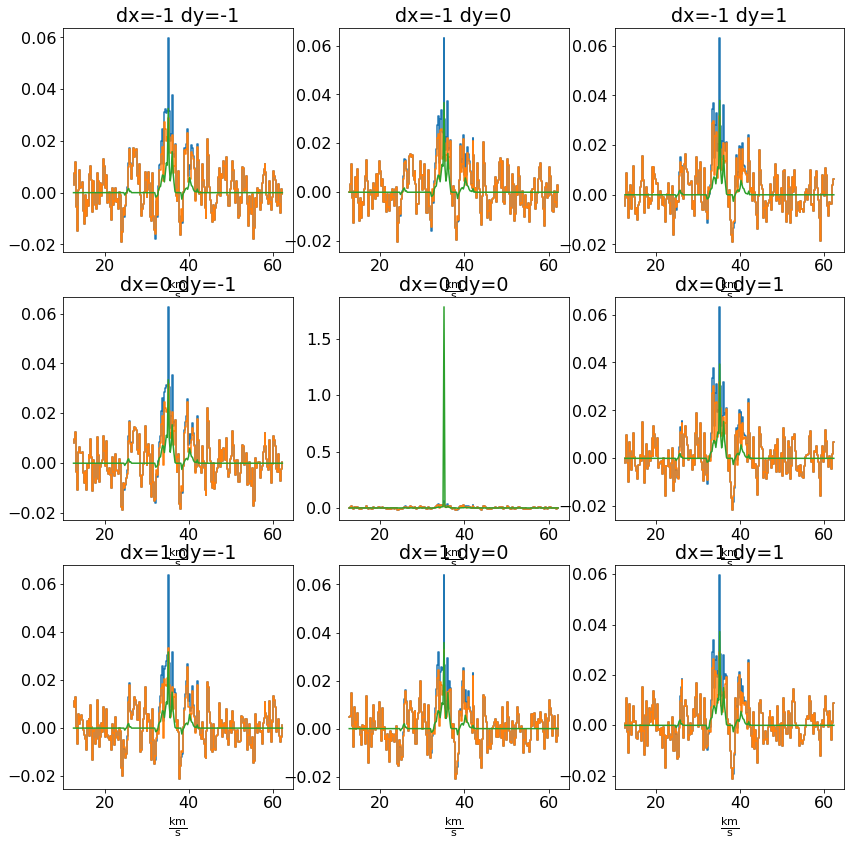

In [16]:
pl.figure(figsize=(14,14))
ii = 1
for dx in (-1,0,1):
    for dy in (-1,0,1):
        ax = pl.subplot(3, 3, ii)
        ii +=1
        cube[:,yy+dy,xx+dx].quicklook()
        resid[:,yy+dy,xx+dx].quicklook()
        modspec = model[:,yy+dy,xx+dx]
        ax.plot(cube.spectral_axis, modspec*cube.pixels_per_beam, label='model')
        ax.set_title(f"dx={dx} dy={dy}")

# When is confetti _not_ a problem?

Here is an example you might think is "confetti", but is a _real_ source

In [17]:
xc, yc = 1812, 905
xslc = slice(xc-12,xc+12)
yslc = slice(yc-12,yc+12)
cubeslice = (slice(94,94+9), yslc, xslc)
cube1slice = (94, yslc, xslc)

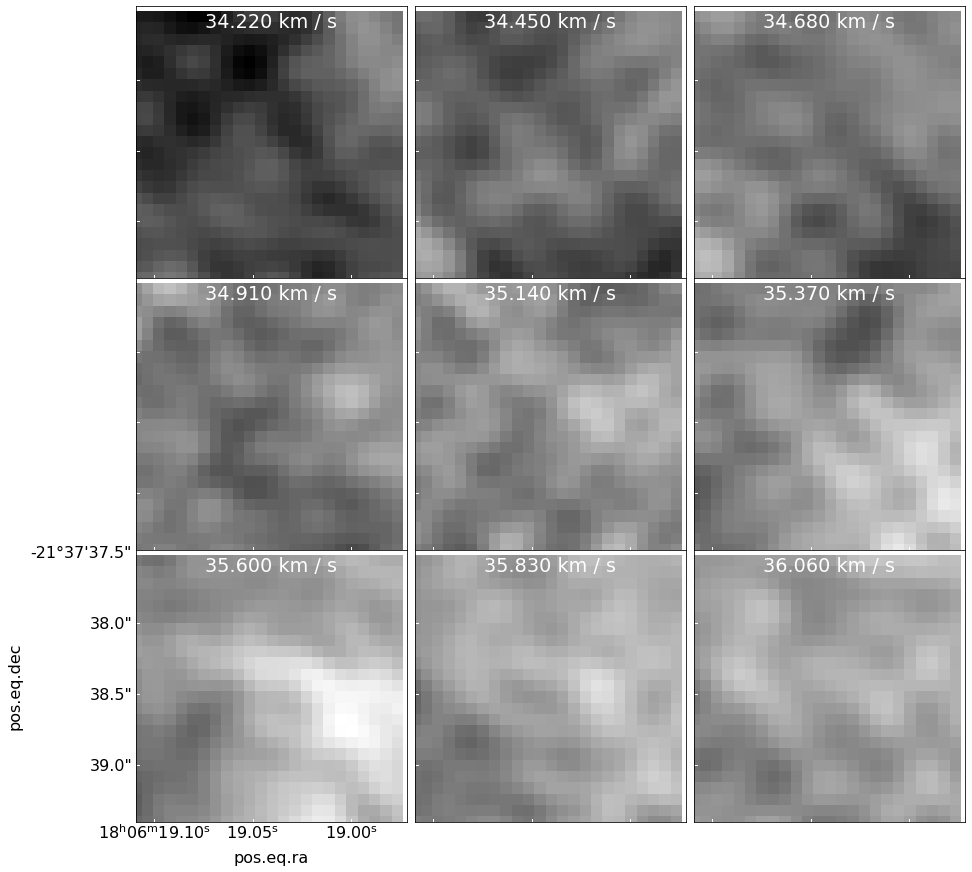

In [18]:
specpix = np.arange(9)
panels = cube[cubeslice].plot_channel_maps(3,3,specpix, fig_smallest_dim_inches=15, norm=simple_norm(cube[cube1slice].value, min_cut=cube[cubeslice].min().value, max_cut=cube[cubeslice].max().value, stretch='linear'))

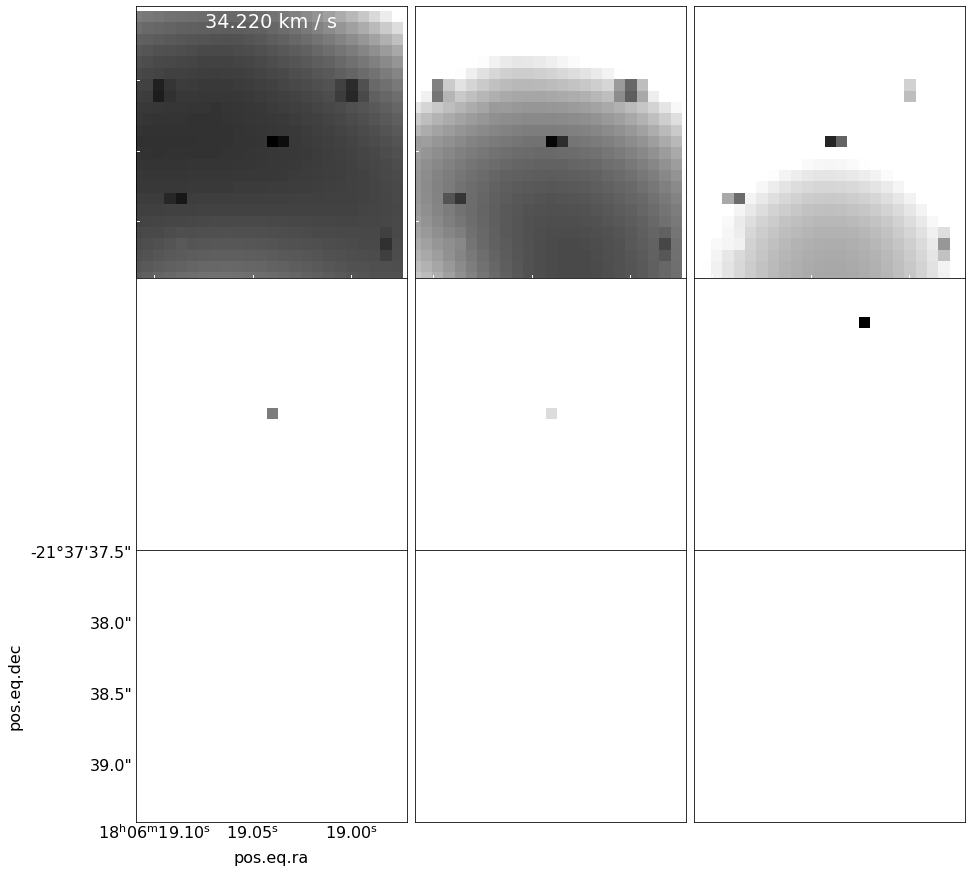

In [19]:
panels = model[cubeslice].plot_channel_maps(3,3,specpix, fig_smallest_dim_inches=15, norm=simple_norm(model[cube1slice].value, stretch='asinh', max_percent=99.9, min_cut=model[cubeslice].min().value, max_cut=model[cubeslice].max().value, ))

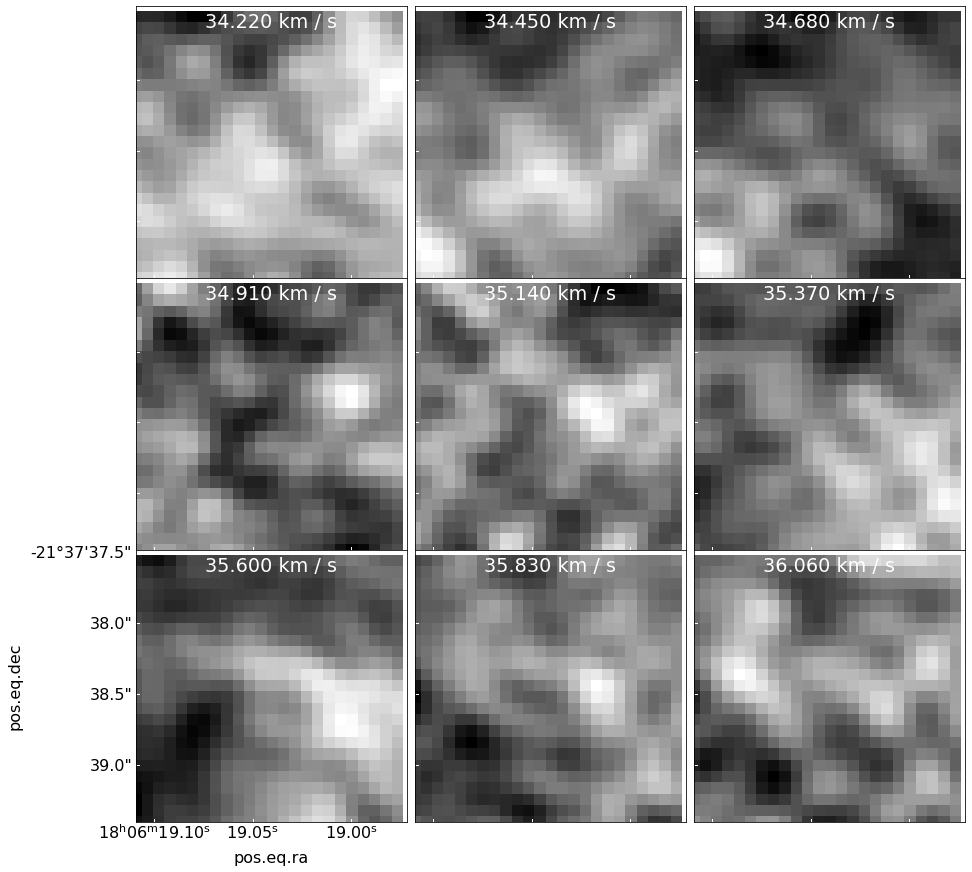

In [20]:
panels = resid[cubeslice].plot_channel_maps(3,3,specpix, fig_smallest_dim_inches=15)

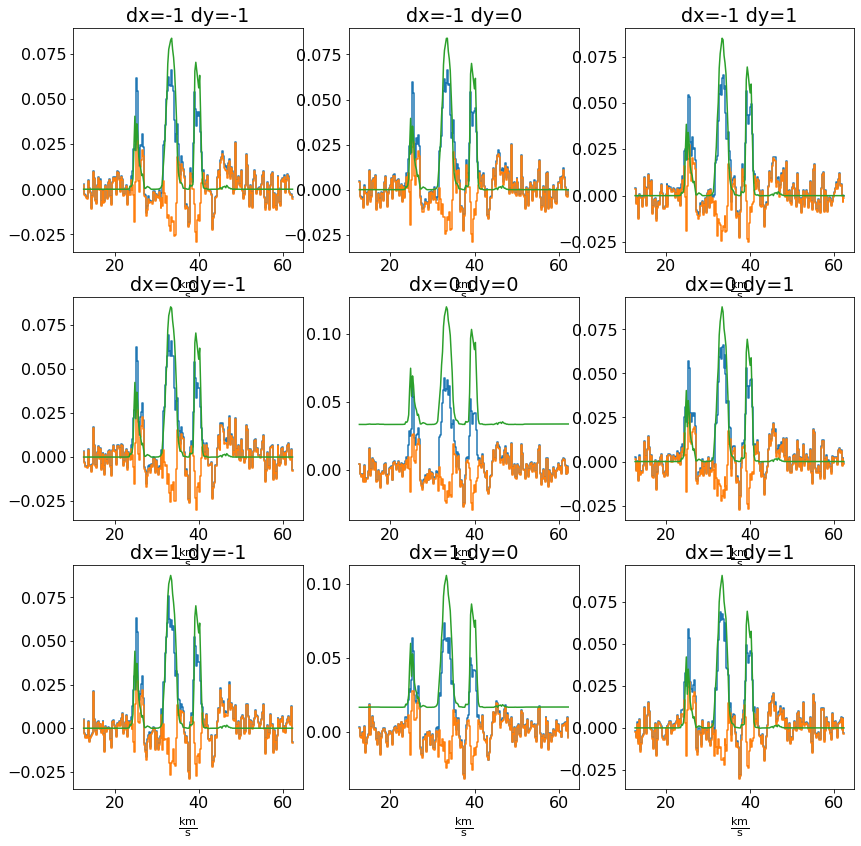

In [21]:
pl.figure(figsize=(14,14))
ii = 1
for dx in (-1,0,1):
    for dy in (-1,0,1):
        ax = pl.subplot(3, 3, ii)
        ii +=1
        cube[:,yc+dy,xc+dx].quicklook()
        resid[:,yc+dy,xc+dx].quicklook()
        modspec = model[:,yc+dy,xc+dx]
        ax.plot(cube.spectral_axis, modspec*cube.pixels_per_beam, label='model')
        ax.set_title(f"dx={dx} dy={dy}")

# Conclusion

"Confetti" is a problem, but it is not trivial to find in the model data alone.  It exhibits no features in the residual.


Key features to look out for are:

 * Narrow-line features (single channel)
 * Extremely bright pointlike peaks in the model (note that this is _not_ independent evidence of a problem!  All point sources occupy single pixels in the model image by definition!)
 * Bright pointlike peaks sitting on top of slightly extended negative backgrounds in the model (this is how the model is "canceled out" in the residual)